In [2]:
set.seed(123)
getwd()
setwd("/liulab/galib/dlbcl_manuscript/")
library(rBCS)
library(tidyverse)
library(Seurat)
library(harmony)
library(viridis)
library(RColorBrewer)
library(Polychrome)
PurpleAndYellow()
library(ComplexHeatmap)
library(devtools)
library(presto)
library(dplyr)
library(ggplot2)
library(ggpubr)
library(readxl)
library(CytoTRACE2)
source("./scripts/scplot.R")

[1] "/liulab/galib/dlbcl_manuscript/scripts"

Warning message:
“package ‘rBCS’ was built under R version 4.1.3”
Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.1 

Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘forcats’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching SeuratObject

Attaching sp

Warning message:
“package ‘harmony’ was built under R version 4.1.3”
Loading required package: Rcpp

Warning message:
“package ‘Rcpp’ was built under R version 4.1.2”
Loading required package: viridisLite

Warning message:
“pack

[1] "#FF00FF" "#F400F4" "#EA00EA" "#DF00DF" "#D500D5" "#CA00CA" "#BF00BF"
 [8] "#B500B5" "#AA00AA" "#9F009F" "#950095" "#8A008A" "#800080" "#750075"
[15] "#6A006A" "#600060" "#550055" "#4A004A" "#400040" "#350035" "#2B002B"
[22] "#200020" "#150015" "#0B000B" "#000000" "#000000" "#0B0B00" "#151500"
[29] "#202000" "#2B2B00" "#353500" "#404000" "#4A4A00" "#555500" "#606000"
[36] "#6A6A00" "#757500" "#808000" "#8A8A00" "#959500" "#9F9F00" "#AAAA00"
[43] "#B5B500" "#BFBF00" "#CACA00" "#D4D400" "#DFDF00" "#EAEA00" "#F4F400"
[50] "#FFFF00"

Warning message:
“package ‘ComplexHeatmap’ was built under R version 4.1.3”
Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: usethis

Warning message:
“package ‘presto’ was built under R version 4.1.3”
Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The

In [3]:
B_cell<- readRDS("./data/objects/B_cell_final.rds")
B_cell_trust4<- read_tsv(file = "./data/B_cell_metadata_trust4_results.tsv", col_names = TRUE)

Rows: 176583 Columns: 42
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (24): orig.ident, sample_id, age, genotype, gender, type, clonality, flo...
dbl (18): nCount_RNA, nFeature_RNA, frozen_cells_x106, spl_g, percent.mt, RN...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [49]:
B_cell_trust4  %>% filter(sample_id %in% c('191', '004', '109', '90b'))  %>% 
    filter(!is.na(cdr3aa))   %>%  select(sample_id, cdr3aa)  %>% count(vars = c('sample_id', 'cdr3aa'))  %>% 
    arrange(sample_id, -freq)  %>% 
    group_by(sample_id) %>% top_n(n = 1)


expanded_cdr3aa<- B_cell_trust4  %>% filter(sample_id %in% c('191', '004', '109', '90b'))  %>% 
    filter(!is.na(cdr3aa))   %>%  select(sample_id, cdr3aa)  %>% count(vars = c('sample_id', 'cdr3aa'))  %>% 
    arrange(sample_id, -freq)  %>% 
    group_by(sample_id) %>% top_n(n = 1)  %>% pull(cdr3aa)

Selecting by freq


sample_id,cdr3aa,freq
<chr>,<chr>,<int>
004,CARIAWRYYGTDFDYW,498
109,CARTLYYGSTPGYFDVW,57
191,CANYGSSYWYFDVW,326
90b,CARTPYGSSFDYW,545


Selecting by freq


In [91]:
B_cell@meta.data  %>% filter(sample_id %in% c('191', '004', '109', '90b'))  %>% 
    count(vars = c("sample_id", "genotype", "age"))

sample_id,genotype,age,freq
<chr>,<chr>,<chr>,<int>
004,CD70-/-;Bcl6tg/+,18mos,1600
109,CD70-/-;Bcl6tg/+,18mos,1138
191,Bcl6tg/+,18mos,1110
90b,CD70-/-;Bcl6tg/+,14mos,1969


In [50]:
expanded_cells<- B_cell_trust4  %>% 
    filter(sample_id %in% c('191', '004', '109', '90b'))  %>%
    filter(!is.na(cdr3aa))  %>% 
    filter(cdr3aa %in% expanded_cdr3aa)  %>% 
    pull(barcode)

In [51]:
B_cell_list = list()
for (sample in c('191', '004', '109', '90b')){
    B_cell_subset = subset(B_cell, sample_id == sample & (Cells(B_cell) %in% expanded_cells))
    message('number of cells in ', sample, ' is: ', dim(B_cell_subset)[2])
    B_cell_list<- c(B_cell_list, B_cell_subset)
}

number of cells in 191 is: 326

number of cells in 004 is: 498

number of cells in 109 is: 57

number of cells in 90b is: 545



In [52]:
combined_cytotrace2<- data.frame()

for ( i in c(1:length(B_cell_list))){
    
    sample<- c('191', '004', '109', '90b')[i]
    B_cell_subset<- B_cell_list[[i]]
    # extract expression data
    expression_data <- B_cell_subset@assays$RNA@counts

    # running CytoTRACE 2 main function - cytotrace2 - with default parameters
    cytotrace2_result <- cytotrace2(expression_data)

    # extract annotation data
    annotation <- B_cell_subset@meta.data$new_annotation
    
    B_cell_subset@meta.data$CytoTRACE2_Score = cytotrace2_result$CytoTRACE2_Score
    B_cell_subset@meta.data$CytoTRACE2_Relative = cytotrace2_result$CytoTRACE2_Relative
    B_cell_subset@meta.data$preKNN_CytoTRACE2_Score = cytotrace2_result$preKNN_CytoTRACE2_Score
    B_cell_subset@meta.data$UMAP_1<- B_cell_subset@reductions$umap@cell.embeddings[,1]
    B_cell_subset@meta.data$UMAP_2<- B_cell_subset@reductions$umap@cell.embeddings[,2]
    
    
    mycol = rev(plasma(n = 10))
    print(quantile(cytotrace2_result$CytoTRACE2_Score))
    p_score<- B_cell_subset@meta.data %>%
        mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
        mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
        ggplot(aes(x = UMAP_1, y= UMAP_2)) +
        geom_point(aes(color = CytoTRACE2_Score), size = 0.5) +
        scale_color_gradientn(colours = mycol, breaks = c(0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9)) +
        theme_bw(base_size = 14) +
        labs(x = "UMAP1", y = "UMAP2", title = paste0(sample, " B-cell score")) +
        theme(legend.title=element_blank())
    
    print(quantile(cytotrace2_result$CytoTRACE2_Relative))
    p_relative<- B_cell_subset@meta.data %>%
        mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
        mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
        ggplot(aes(x = UMAP_1, y= UMAP_2)) +
        geom_point(aes(color = CytoTRACE2_Relative), size = 0.5) +
        scale_color_gradientn(colours = mycol, breaks = c(0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9)) +
        theme_bw(base_size = 14) +
        labs(x = "UMAP1", y = "UMAP2", title = paste0(sample, " B-cell relative score")) +
        theme(legend.title=element_blank())
    
    print(quantile(cytotrace2_result$preKNN_CytoTRACE2_Score))
    p_preknn<- B_cell_subset@meta.data %>%
        mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
        mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
        ggplot(aes(x = UMAP_1, y= UMAP_2)) +
        geom_point(aes(color = preKNN_CytoTRACE2_Score), size = 0.5) +
        scale_color_gradientn(colours = mycol, breaks = c(0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9)) +
        theme_bw(base_size = 14) +
        labs(x = "UMAP1", y = "UMAP2", title = paste0(sample, " B-cell pre knn score")) +
        theme(legend.title=element_blank())
    
    ggsave(paste0("./results/figures/9_cytotrace2_score_", sample, "_umap.pdf"), p_score, width = 4, height =3)
    ggsave(paste0("./results/figures/9_cytotrace2_relative_", sample, "_umap.pdf"), p_relative, width = 4, height =3)
    ggsave(paste0("./results/figures/9_cytotrace2_preknn_score_", sample, "_umap.pdf"), p_preknn, width = 4, height =3)
    
    combined_cytotrace2<- rbind(combined_cytotrace2, cytotrace2_result)
    
    message('done ', sample)

}

cytotrace2: Started loading data

Dataset contains 32285 genes and 326 cells.

The number of cells in your dataset is less than 1000. Fast mode has been disabled.

The passed subsample size is greater than the number of cells in dataset.
Now setting subsample size to 326

cytotrace2: Running on 1 subsample(s) approximately of length 326

cytotrace2: Started running on subsample(s). This will take a few minutes.

cytotrace2: Started preprocessing.

The function expects an input of type 'data.frame' or 'data.table'.
Attempting to convert the provided input to the required format.

14133 input genes mapped to model genes.

cytotrace2: Started prediction.

This section will run using  5 / 72 core(s).

cytotrace2: Started postprocessing.

The passed subsample size is greater than the number of cells in the subsample.
Now setting subsample size to 326
Please consider reducing the smooth_batch_size to a number in range 1000 - 3000 for runtime and memory efficiency.

cytotrace2: Running with s

         0%         25%         50%         75%        100% 
0.006134979 0.081799591 0.166155409 0.261986300 0.499999990 
       0%       25%       50%       75%      100% 
0.0000000 0.2461538 0.5000000 0.7500000 1.0000000 
        0%        25%        50%        75%       100% 
0.00000001 0.08307771 0.16615541 0.25770548 0.58333333 


done 191

cytotrace2: Started loading data

Dataset contains 32285 genes and 498 cells.

The number of cells in your dataset is less than 1000. Fast mode has been disabled.

The passed subsample size is greater than the number of cells in dataset.
Now setting subsample size to 498

cytotrace2: Running on 1 subsample(s) approximately of length 498

cytotrace2: Started running on subsample(s). This will take a few minutes.

cytotrace2: Started preprocessing.

The function expects an input of type 'data.frame' or 'data.table'.
Attempting to convert the provided input to the required format.

14133 input genes mapped to model genes.

cytotrace2: Started prediction.

This section will run using  5 / 72 core(s).

cytotrace2: Started postprocessing.

The passed subsample size is greater than the number of cells in the subsample.
Now setting subsample size to 498
Please consider reducing the smooth_batch_size to a number in range 1000 - 3000 for runtime and memory efficiency.

cytotrace2: Runn

         0%         25%         50%         75%        100% 
0.007720263 0.071412354 0.121480468 0.245934960 0.499999990 
       0%       25%       50%       75%      100% 
0.0000000 0.2500000 0.5000000 0.7497485 1.0000000 
        0%        25%        50%        75%       100% 
0.00000001 0.05642598 0.11285195 0.18597562 0.66666666 


done 004

cytotrace2: Started loading data

Dataset contains 32285 genes and 57 cells.

The number of cells in your dataset is less than 1000. Fast mode has been disabled.

The passed subsample size is greater than the number of cells in dataset.
Now setting subsample size to 57

cytotrace2: Running on 1 subsample(s) approximately of length 57

cytotrace2: Started running on subsample(s). This will take a few minutes.

cytotrace2: Started preprocessing.

The function expects an input of type 'data.frame' or 'data.table'.
Attempting to convert the provided input to the required format.

14133 input genes mapped to model genes.

cytotrace2: Started prediction.

This section will run using  5 / 72 core(s).

cytotrace2: Started postprocessing.

The passed subsample size is greater than the number of cells in the subsample.
Now setting subsample size to 57
Please consider reducing the smooth_batch_size to a number in range 1000 - 3000 for runtime and memory efficiency.

cytotrace2: Running 

        0%        25%        50%        75%       100% 
0.00000001 0.17592593 0.30555555 0.40579710 0.75000000 
  0%  25%  50%  75% 100% 
0.00 0.25 0.50 0.75 1.00 
        0%        25%        50%        75%       100% 
0.00000001 0.17592593 0.30555555 0.40579710 0.75000000 


done 109

cytotrace2: Started loading data

Dataset contains 32285 genes and 545 cells.

The number of cells in your dataset is less than 1000. Fast mode has been disabled.

The passed subsample size is greater than the number of cells in dataset.
Now setting subsample size to 545

cytotrace2: Running on 1 subsample(s) approximately of length 545

cytotrace2: Started running on subsample(s). This will take a few minutes.

cytotrace2: Started preprocessing.

The function expects an input of type 'data.frame' or 'data.table'.
Attempting to convert the provided input to the required format.

14133 input genes mapped to model genes.

cytotrace2: Started prediction.

This section will run using  5 / 72 core(s).

cytotrace2: Started postprocessing.

The passed subsample size is greater than the number of cells in the subsample.
Now setting subsample size to 545
Please consider reducing the smooth_batch_size to a number in range 1000 - 3000 for runtime and memory efficiency.

cytotrace2: Runn

         0%         25%         50%         75%        100% 
0.004240892 0.085241730 0.134435957 0.227564105 0.484496116 
       0%       25%       50%       75%      100% 
0.0000000 0.2527574 0.4990809 0.7500000 1.0000000 
        0%        25%        50%        75%       100% 
0.00000001 0.05767600 0.11535199 0.18910257 0.75000000 


done 90b



In [53]:
B_cell@meta.data$UMAP_1<- B_cell@reductions$umap@cell.embeddings[,1]
B_cell@meta.data$UMAP_2<- B_cell@reductions$umap@cell.embeddings[,2]
B_cell_four_samples<- subset(B_cell, cells = expanded_cells)
df<- cbind(B_cell_four_samples@meta.data, combined_cytotrace2[Cells(B_cell_four_samples), ])

In [71]:
quantile(df$CytoTRACE2_Score, c(0.1, 0.25, 0.5, 0.75, 0.9))
quantile(df$CytoTRACE2_Relative)

10%        25%        50%        75%        90% 
0.04703477 0.08179959 0.13692097 0.26275465 0.38433668

0%       25%       50%       75%      100% 
0.0000000 0.2463235 0.4995404 0.7503773 1.0000000

In [74]:
df$CytoTRACE2_Score_scaled = df$CytoTRACE2_Score
df[df$CytoTRACE2_Score > 0.4, 'CytoTRACE2_Score_scaled'] = 0.4

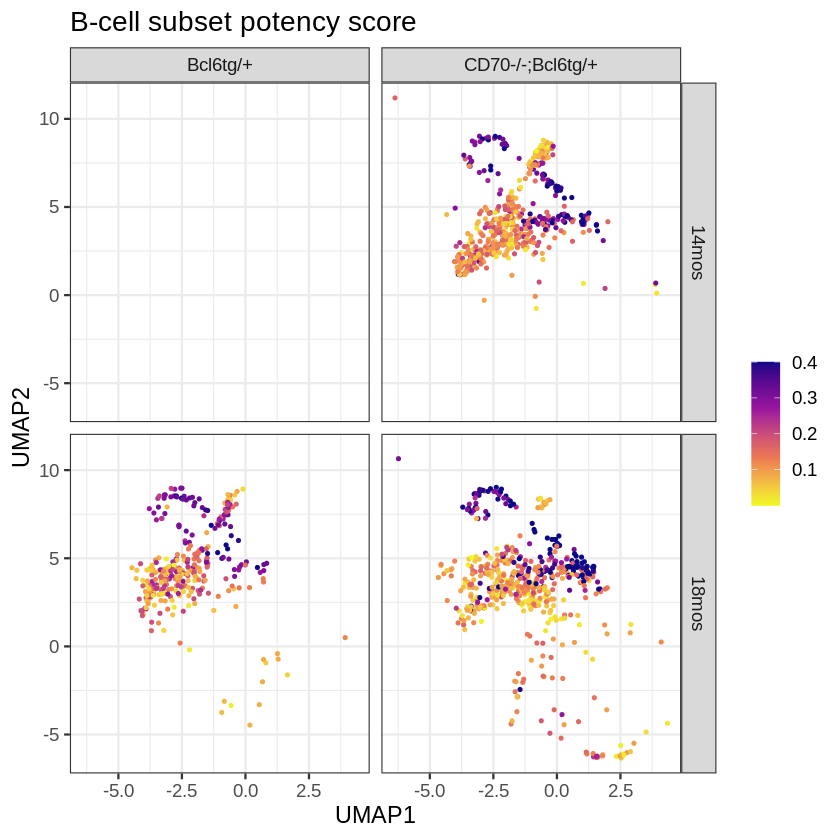

In [81]:
mycol = rev(plasma(n = 4))
df %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genaotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = CytoTRACE2_Score_scaled), size = 0.8) +
    scale_color_gradientn(colours = mycol, breaks = c(0.1, 0.2, 0.3, 0.4)) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "B-cell subset potency score") +
    theme(legend.title=element_blank()) +
    facet_grid(age ~ genotype)

ggsave("./results/figures/9_cytotrace2_combined_score_by_age_by_genotype.pdf", width = 6, height =5)

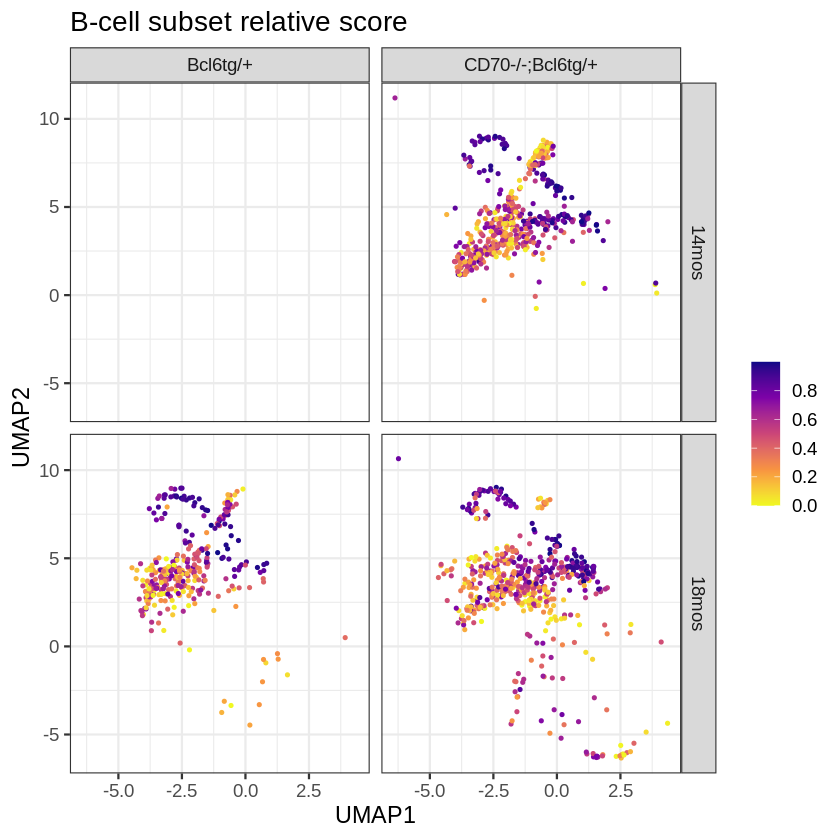

In [82]:
mycol = rev(plasma(n = 5))

df %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genaotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = CytoTRACE2_Relative), size = 0.8) +
    scale_color_gradientn(colours = mycol, breaks = c(0, 0.2, 0.4, 0.6, 0.8)) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "B-cell subset relative score") +
    theme(legend.title=element_blank()) +
    facet_grid(age ~ genotype)

ggsave("./results/figures/9_cytotrace2_combined_relative_score_by_age_by_genotype.pdf", width = 6, height =5)

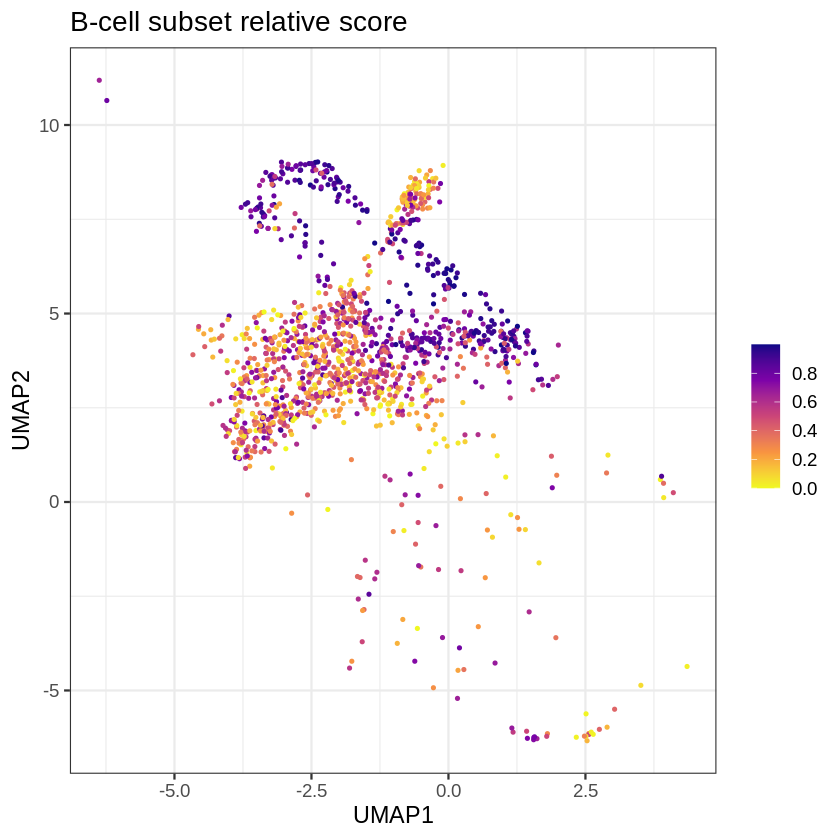

In [83]:
mycol = rev(plasma(n = 5))

df %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genaotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = CytoTRACE2_Relative), size = 0.8) +
    scale_color_gradientn(colours = mycol, breaks = c(0, 0.2, 0.4, 0.6, 0.8)) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "B-cell subset relative score") +
    theme(legend.title=element_blank())

ggsave("./results/figures/9_cytotrace2_combined_relative_score.pdf", width = 6, height =5)

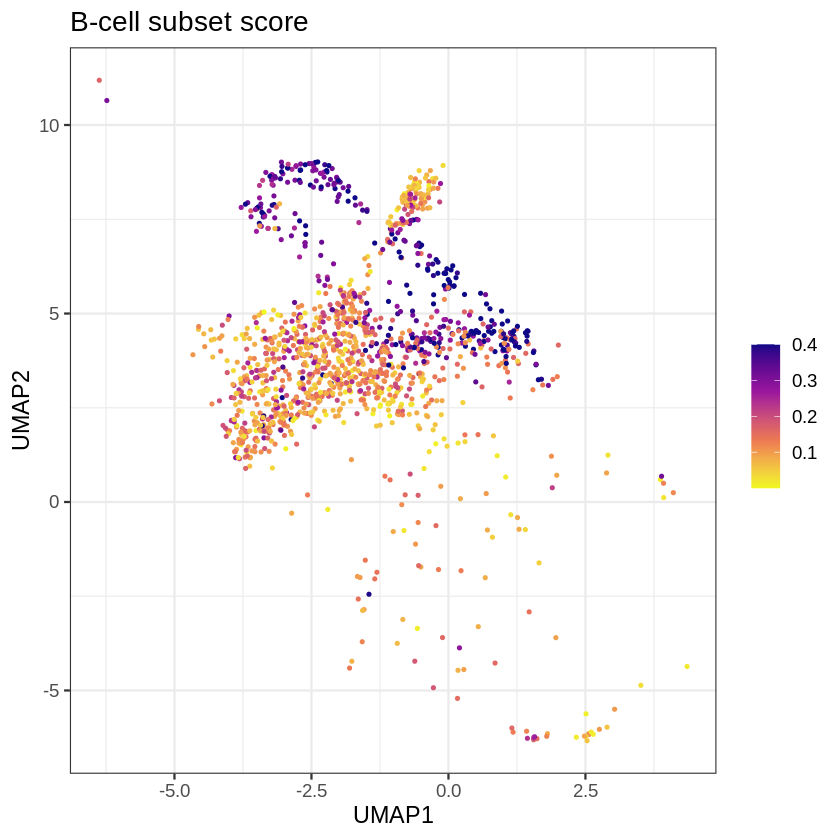

In [85]:
mycol = rev(plasma(n = 4))

df %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genaotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = CytoTRACE2_Score_scaled), size = 0.8) +
    scale_color_gradientn(colours = mycol, breaks = c(0.1, 0.2, 0.3, 0.4)) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "B-cell subset score") +
    theme(legend.title=element_blank())

ggsave("./results/figures/9_cytotrace2_combined_score.pdf", width = 6, height =5)

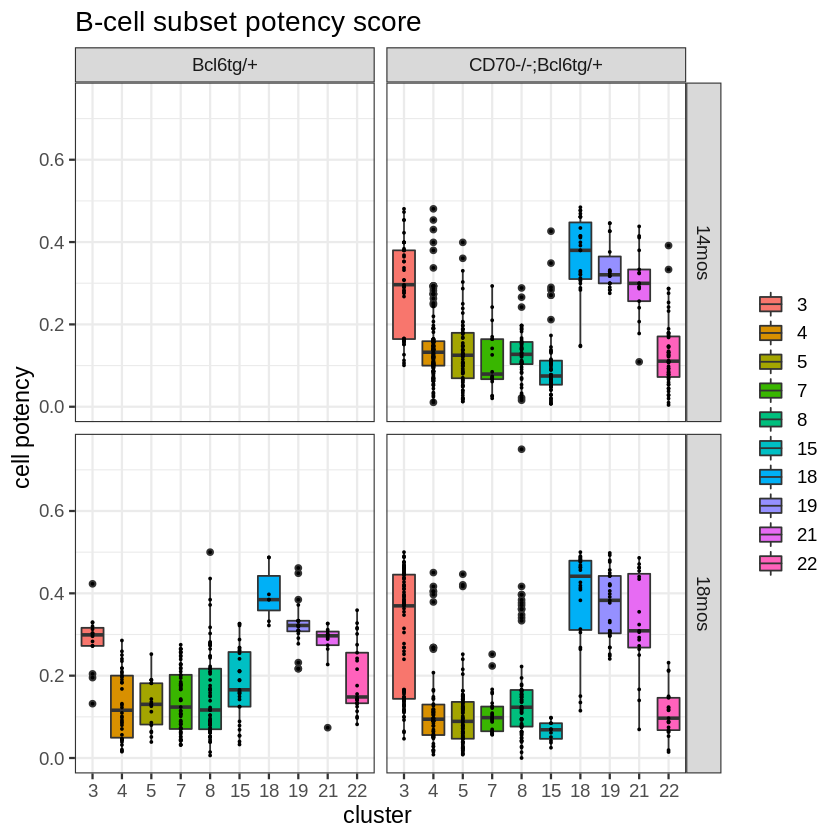

In [86]:
df  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genaotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    filter(seurat_clusters %in% c(3, 4, 5, 7, 8, 15, 18, 19, 21, 22))  %>% 
    ggplot(aes(x = seurat_clusters, y = CytoTRACE2_Score))  +
    geom_boxplot(aes(fill = seurat_clusters)) +
    geom_point(size = 0.4) +
    theme_bw(base_size = 14) +
    labs(x = "cluster ", y = "cell potency", title = "B-cell subset potency score") +
    theme(legend.title=element_blank()) +
    facet_grid(age ~ genotype)


ggsave("./results/figures/9_cytotrace2_combined_score_boxplot.pdf", width = 6, height =5)